In [47]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
map = gpd.read_file('../data/AgrImOnIa/raw/AreasGeometriesWithNames.shp')
map = map.to_crs({'init': 'epsg:4326'})
map.head()

# Dimensions of the map
print(map.shape)

(427, 3)


C:\Users\DVX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [49]:
model_file_name = "../output/Oct2017_March2018_30wind_10m_reduced.csv"
model_data = gpd.read_file(model_file_name)

model_data.head()
model_data.shape

(427, 28)

In [50]:
geometry_cols = map[["MUNICIPALI", "geometry"]]
merged_df = pd.merge(model_data, geometry_cols, left_on="Municipality_Name", right_on="MUNICIPALI", how="inner")
merged_df.drop(["MUNICIPALI", "geometry_x"], axis=1, inplace=True)
merged_df.rename(columns={"geometry_y": "geometry"}, inplace=True)

# shift back the predictions by the initial value
mean_shift = pd.to_numeric(merged_df["PM25_original"], errors="coerce").mean()
merged_df["PM25_predictions"] = pd.to_numeric(merged_df["PM25_predictions"], errors="coerce") + mean_shift

merged_df.head()
merged_df.shape

(427, 28)

C:\Users\DVX\AppData\Local\Temp\ipykernel_15980\4181105835.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df["PM25_original"].replace("NA", pd.NA, inplace=True)


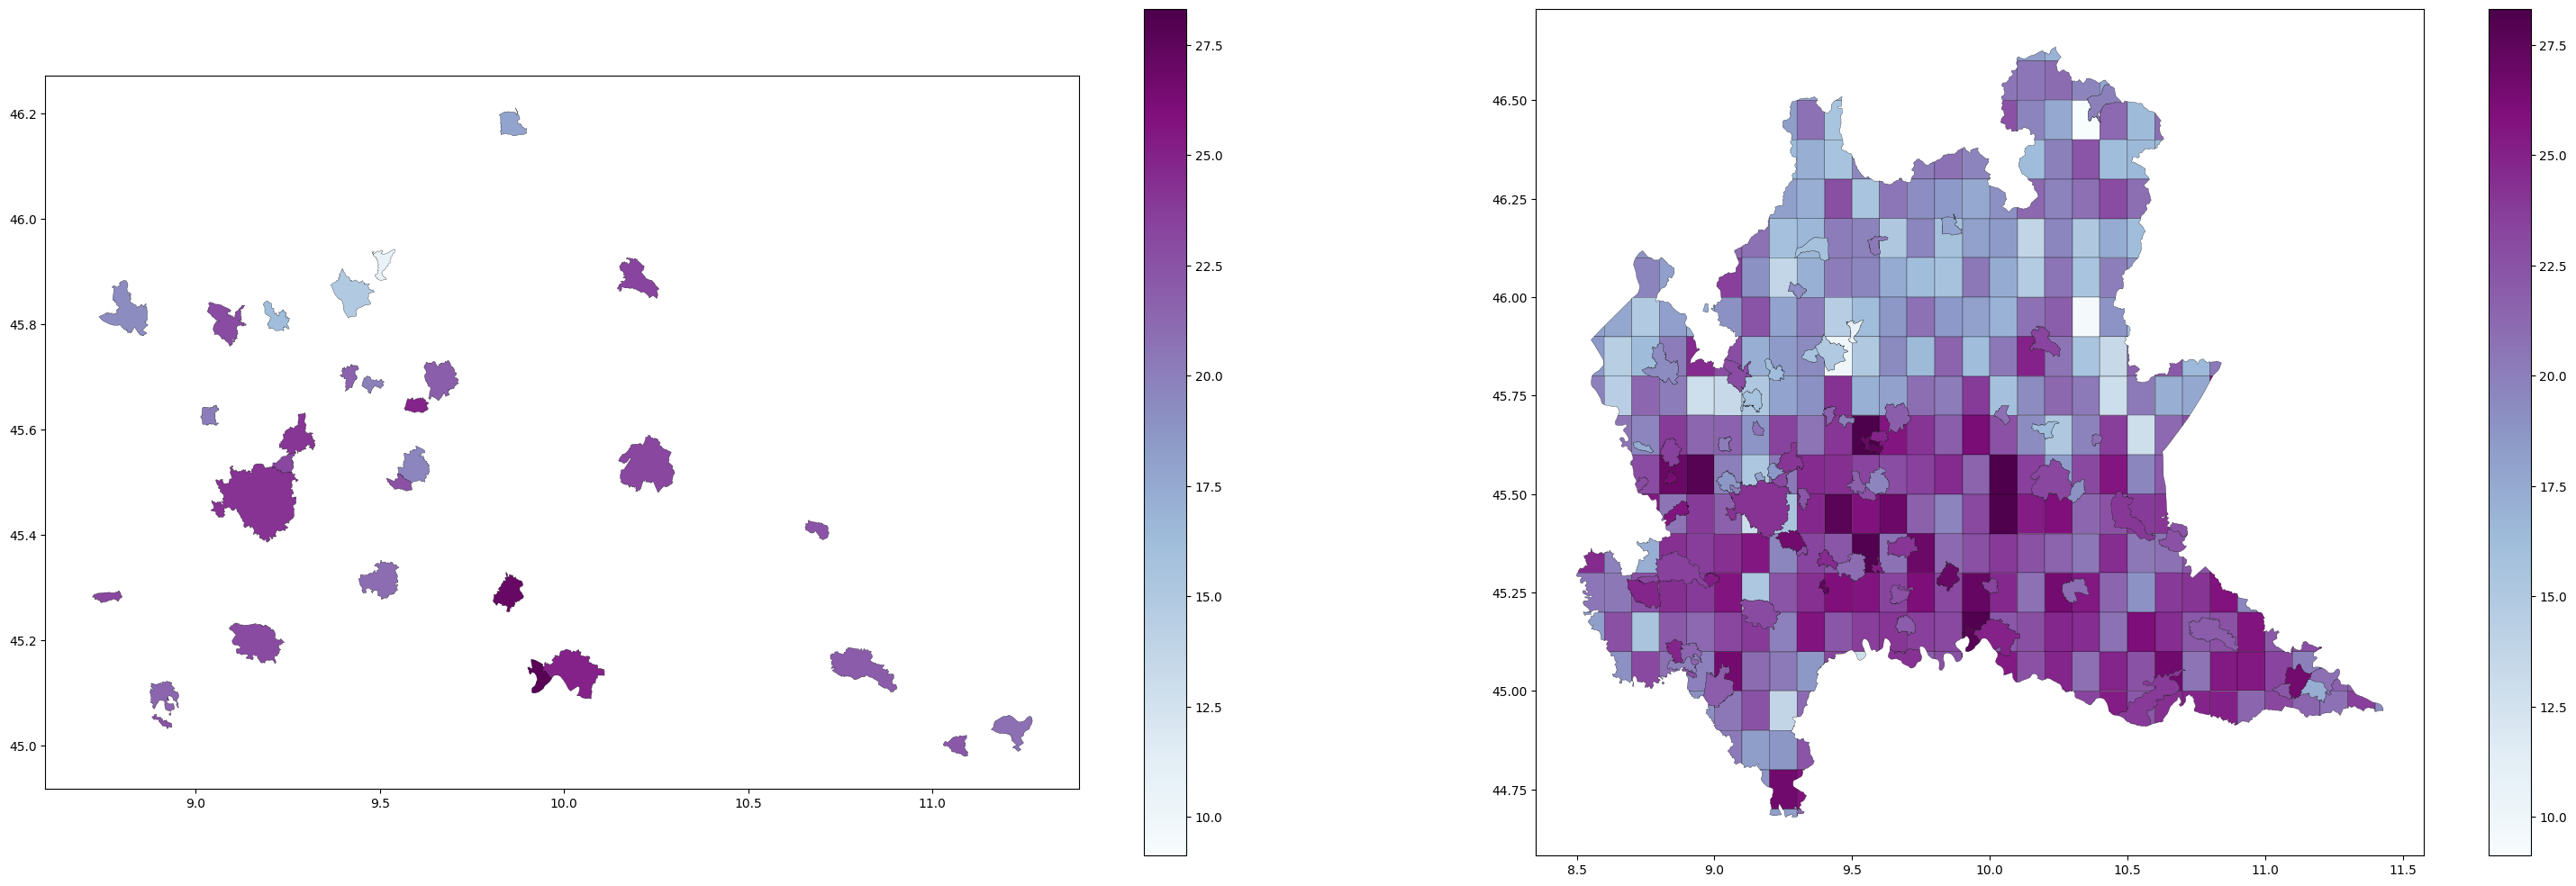

In [51]:
merged_df = merged_df.to_crs(map.crs)
cleaned_df = merged_df
cleaned_df["PM25_original"].replace("NA", pd.NA, inplace=True)
cleaned_df["PM25_original"] = pd.to_numeric(cleaned_df["PM25_original"])
cleaned_df["PM25_predictions"] = pd.to_numeric(cleaned_df["PM25_predictions"])
cleaned_df.fillna(0, inplace=True)
# merged_df.plot(column="PM25_predictions", legend=True, cmap="BuPu")

min_value = min(min(cleaned_df["PM25_predictions"]), min(cleaned_df["PM25_original"]))
max_value = max(max(cleaned_df["PM25_predictions"]), max(cleaned_df["PM25_original"]))

fig, axs = plt.subplots(1, 2, figsize=(30, 10))

plt.tight_layout()
plot_values = ["PM25_original", "PM25_predictions"]
for i, ax in enumerate(axs): 
    cleaned_df.plot(
        ax=ax, 
        column=plot_values[i], 
        legend=True, 
        cmap="BuPu", 
        edgecolor='black', 
        linewidth=0.2,
        vmin=min_value,
        vmax=max_value
    )

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, 'LI_pigs'),
  Text(1, 0, 'EM_nh3_agr_soils'),
  Text(2, 0, 'EM_nh3_agr_waste_burn'),
  Text(3, 0, 'WE_rh_min'),
  Text(4, 0, 'WE_wind_speed_10m_mean'),
  Text(5, 0, 'LA_land_use'),
  Text(6, 0, 'LI_bovine'),
  Text(7, 0, 'WE_blh_layer_max'),
  Text(8, 0, 'WE_rh_max'),
  Text(9, 0, 'WE_blh_layer_min'),
  Text(10, 0, 'Altitude'),
  Text(11, 0, 'EM_so2_sum'),
  Text(12, 0, 'WE_tot_precipitation'),
  Text(13, 0, 'WE_wind_speed_10m_max'),
  Text(14, 0, 'WE_surface_pressure'),
  Text(15, 0, 'EM_nox_traffic'),
  Text(16, 0, 'EM_nox_sum'),
  Text(17, 0, 'WE_rh_mean'),
  Text(18, 0, 'LA_lvi'),
  Text(19, 0, 'LA_hvi'),
  Text(20, 0, 'EM_nh3_sum'),
  Text(21, 0, 'WE_solar_radiation'),
  Text(22, 0, 'EM_nh3_livestock_mm'),
  Text(23, 0, 'WE_temp_2m')])

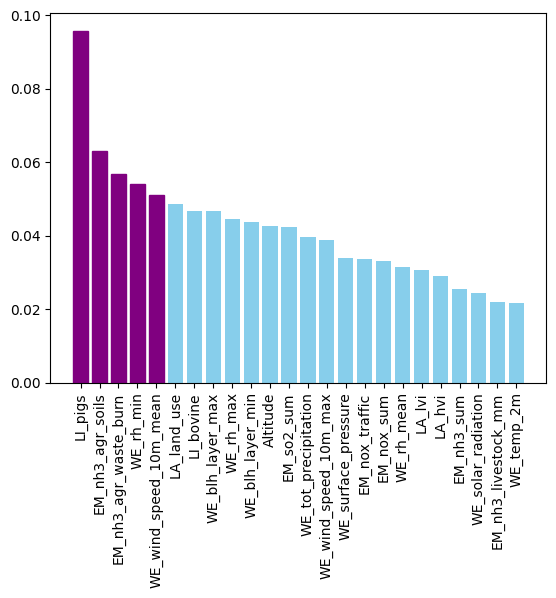

In [52]:
covariates_sel_file_name = "../output/Oct2017_March2018_30wind_10m_reduced_cov_inclusion.csv"
covariates_selection = pd.read_csv(covariates_sel_file_name)

burnin = 5000
covariates_selection = covariates_selection.iloc[burnin:]
inclusion_probabilities = covariates_selection.sum(axis=0)
inclusion_probabilities = inclusion_probabilities / sum(inclusion_probabilities)

inclusion_probabilities = pd.DataFrame(inclusion_probabilities.sort_values(ascending=False))
inclusion_probabilities.columns = ["Inclusion_probability"]

bars = plt.bar(inclusion_probabilities.index, inclusion_probabilities["Inclusion_probability"], color="skyblue")

# highlight highest inclusion probabilities
for i, bar in enumerate(bars):
    if i < 5: 
        bar.set_color('purple')
        
plt.xticks(rotation=90)